In [1]:
# install dependencies
!pip install matplotlib
!pip install sqlalchemy
!pip install pandas
!pip install scikit-learn
!pip install prophet
!pip install statsmodels
!pip install seaborn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import 

In [2]:
from pathlib import Path
import sys
import os

ROOT_DIR = Path().resolve().parent
sys.path.append(str(ROOT_DIR))

#from sqlalchemy import create_engine
#from sqlalchemy import text
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import periodogram
from prophet import Prophet
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import statsmodels.api as sm
import seaborn as sns
import joblib
from scripts.features_utils import get_features_arima, select_features_arima, get_data, r2_score_real


C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Pull the data
Take the same aggregation level than the previous model, passengers of one route aggregated by service date.

In [3]:
# pull the data. the aggregation data is per day
data = get_data()

if data is None:
    #there was an error fetching the data. exiting
    sys.exit("Couldn't open data from database or file. Aborting.")

In [4]:
data.shape

(1186, 11)

In [5]:
# explore the data
data.head()

,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,day_category,price_mix_ratio
0,MAK-MAD,2021,53,2022-01-01,2579,12,419576.00,451077.0000,960687.672,Christmas,1.12900348972469949593
1,MAK-MAD,2022,1,2022-01-02,2038,12,343511.50,374778.0000,771785.126,Christmas,1.12644749754661432777
2,MAK-MAD,2022,1,2022-01-03,1900,12,320459.00,345114.5000,730788.374,Christmas,1.14226315789473684211
3,MAK-MAD,2022,1,2022-01-04,1810,12,306953.00,329255.0000,674187.758,Christmas,1.17303867403314917127
4,MAK-MAD,2022,1,2022-01-05,2440,14,395531.00,422114.0000,936571.790,Christmas,1.14508196721311475410


## Plot the original data

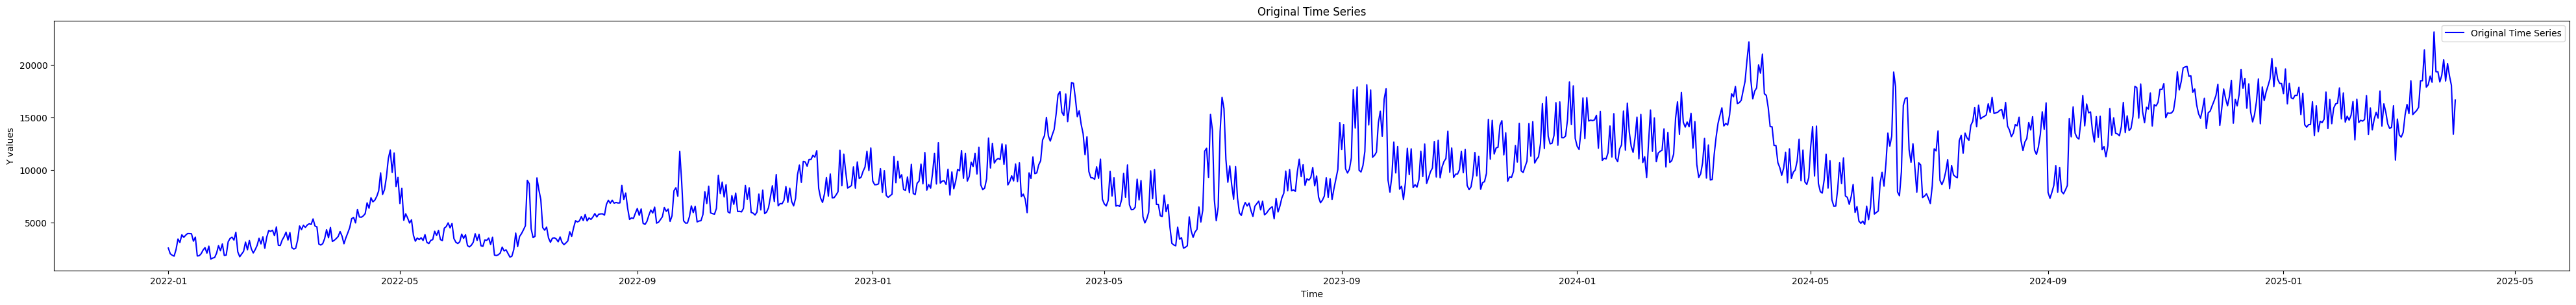

In [6]:
# load data
data.sort_values('train_departure_date_short', inplace=True)
ts_r1 = data["passengers"]
days = pd.to_datetime(data["train_departure_date_short"])

#time = np.arange(ts.shape[0])
time = range(len(ts_r1))

# Convert to DataFrame
df_r1 = pd.DataFrame({"date": days, "Y": ts_r1})
df_r1.set_index("date", inplace=True)
df_r1.sort_index(inplace=True)

# Plot the original time series
plt.figure(figsize=(50, 5))
plt.plot(df_r1["Y"], label="Original Time Series", color="blue")
plt.xlabel("Time")
plt.ylabel("Y values")
plt.title("Original Time Series")
plt.legend()
plt.show()


In [7]:
df_r1.shape

(1186, 1)

In [8]:
# standarize the data 
# tested to see if improve the converge
# discarded

#sc = StandardScaler()
#ts_r1_std = sc.fit_transform(ts_r1.to_frame())
#df_r1["Y"] = ts_r1_std

## Stationarity (d=1)
After doing the Advanced Fuller test, the results are somewhat in the edge. According to the numbers, we are supposed to accept the null hypotesis and asert with 95% of confidence that the data is stationary. <br>
Anyhow, in the plot, visually we can confirm some ascending trend (and the prior knowledge confirms that there is a growing in the demand along time). <br>
For that reason, one degree of differentiation is applied, getting now a 99% of confidence. <br>
Visually, it is not possible to detect trends in the final data. <br>

In [9]:
df_r1.shape

(1186, 1)

In [10]:
# run advanced fuller test
adf_result = adfuller(df_r1["Y"])

# display ADF test results
adf_result

(np.float64(-2.243191485313914),
 np.float64(0.19094438198186492),
 21,
 1164,
 {'1%': np.float64(-3.4359803948357723),
  '5%': np.float64(-2.8640262259528595),
  '10%': np.float64(-2.5680937227063922)},
 np.float64(19943.414706517127))

In [11]:
# run the test again after one order of differentiation
ts_r1_diff = df_r1["Y"].diff().dropna()
adf_result = adfuller(ts_r1_diff)
# display
adf_result

(np.float64(-9.904701837096033),
 np.float64(3.286968679322885e-17),
 20,
 1164,
 {'1%': np.float64(-3.4359803948357723),
  '5%': np.float64(-2.8640262259528595),
  '10%': np.float64(-2.5680937227063922)},
 np.float64(19930.509587964778))

In [12]:
df_r1.shape

(1186, 1)

[]

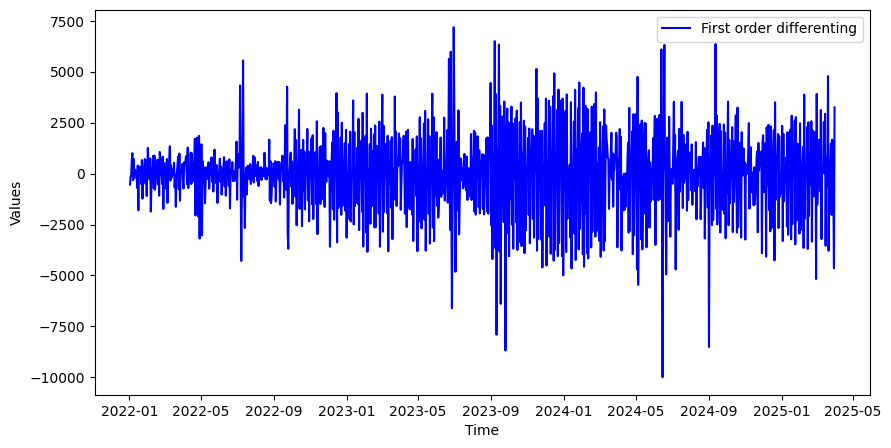

In [13]:
# plot the data after differentiation
plt.figure(figsize=(10,5))
plt.plot(ts_r1_diff, label="First order differenting", color="Blue")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.plot()

In [14]:
param_d = 1

In [15]:
df_r1.shape

(1186, 1)

## AR (p=7)
Taking the Partial Autocorrelation function, the seventh lag is the last very significant

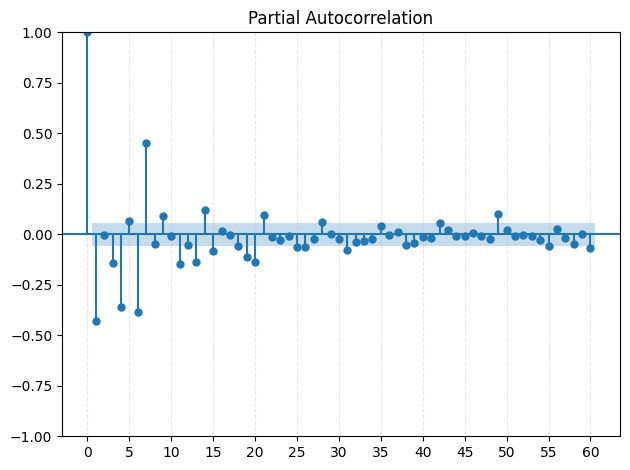

In [16]:
# plot the partial auto correlation function (PACF)
lags_chosen = 60
plot_pacf(ts_r1_diff, lags=lags_chosen) 
plt.xticks(range(0, lags_chosen + 1, 5))
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [17]:
# based on the results, the paramters selected is...
param_p = 7

In [18]:
df_r1.shape

(1186, 1)

## MA (q=2)
After checking the Autocorrelation plot, there is some seasonality not corrected (probably weekly, yearly trends).
By the moment, we will take the most significant terms (until just before the first non significant item) and will work on seasonality. <br>
There is also some slow decay when checking the long term plot, which could indicate a trend in the data.

<Figure size 800x500 with 0 Axes>

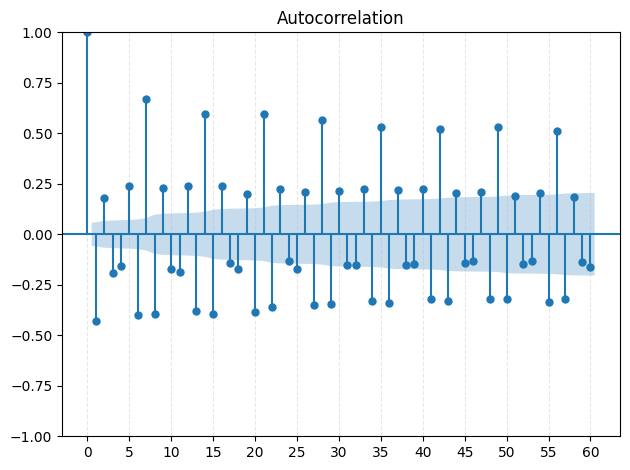

In [19]:
# plot the autocrrelation function (ACF)
plt.figure(figsize=(8,5))

lags_chosen = 60
plot_acf(ts_r1_diff, lags=lags_chosen) 
plt.xticks(range(0, lags_chosen + 1, 5))
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
df_r1.shape

(1186, 1)

<Figure size 800x500 with 0 Axes>

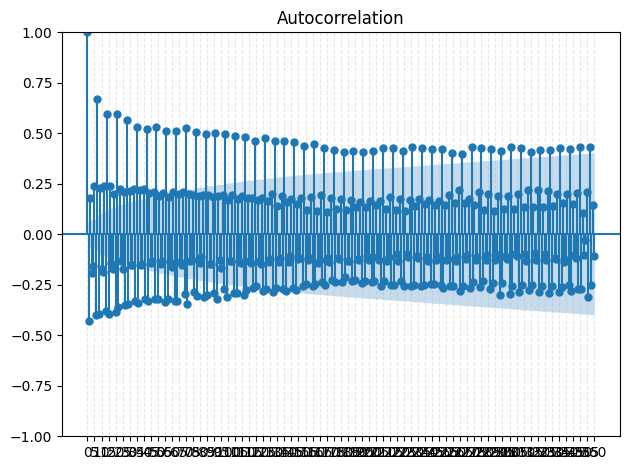

In [21]:
# plot the autocrrelation function (ACF) for longer period to see the trend. 
plt.figure(figsize=(8,5))

lags_chosen = 360
plot_acf(ts_r1_diff, lags=lags_chosen) 
plt.xticks(range(0, lags_chosen + 1, 5))
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# based on the results, the parameter selected is...
param_q = 2

In [23]:
df_r1.shape

(1186, 1)

## ARMA (p=7, q=0)
After testing the options of the previous sections, it is confirmed that the best option for p is 7, since increase that parameter lead to decrease on performance. Regarding q, seems that is not consistent its worth, specially for higher values of p (possibly the information es redundant). The ARIMA model will be done with p=7 and q=0

In [24]:
# after the findings of the previous sections, confirm the BIC around those values for the paramters p and q
print(arma_order_select_ic(
    ts_r1_diff.astype(float) , 
    max_ar=param_p+1, 
    max_ma=param_q+1, 
    ic='bic', 
    trend='c', 
    model_kw=None, 
    fit_kw=None))

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

{'bic':               0             1             2             3
0  21346.735347  21099.134573  21103.640499  21019.266027
1  21112.580657  21119.642858  21066.079340  21004.423264
2  21119.652891  21064.161812  21074.493232  20942.565191
3  21102.352541  21033.067293  20902.056882  20652.673176
4  20942.984607  20772.194103  20765.528627  20956.287842
5  20944.525886  20957.133361  20761.217273  20757.229344
6  20761.401281  20592.284983  20520.286090  20526.654457
7  20490.974465  20492.764620  20495.206092  20502.120582
8  20494.761720  20498.154332  20502.244154  20491.055674, 'bic_min_order': (np.int64(7), np.int64(0))}


C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# based on the results, one parameter is changed
param_q = 0

## ARIMA (7, 1, 0)
The model is created without seasonality as a first approach. <br>
After checking the residuals, there is a obvious relation every seven days, due a weekly seasonality, besides the result of the Ljung-box test. <br>
The test also show Heteroskedasticity and residuals not showing a normal distribution. This should be checked later on, after the seasonality clean, but most probably there is a trend (a growing demand year after year) not properly cleant. <br>

In [26]:
model_ar = ARIMA(ts_r1.astype(int), order=(param_p,param_d,param_q)).fit()
print(model_ar.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                 1186
Model:                 ARIMA(7, 1, 0)   Log Likelihood              -10213.614
Date:                Tue, 13 May 2025   AIC                          20443.228
Time:                        08:04:26   BIC                          20483.848
Sample:                             0   HQIC                         20458.539
                               - 1186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2531      0.021    -12.202      0.000      -0.294      -0.212
ar.L2         -0.1471      0.019     -7.649      0.000      -0.185      -0.109
ar.L3         -0.2427      0.017    -14.051      0.0

In [27]:
param_p = [1,2,3,4,6,7]
model_ar = ARIMA(ts_r1.astype(int), order=(param_p,param_d,param_q)).fit()
print(model_ar.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          passengers   No. Observations:                 1186
Model:             ARIMA([1, 2, 3, 4, 6, 7], 1, 0)   Log Likelihood              -10213.853
Date:                             Tue, 13 May 2025   AIC                          20441.706
Time:                                     08:04:27   BIC                          20477.249
Sample:                                          0   HQIC                         20455.103
                                            - 1186                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2469      0.020    -12.274      0.000      -0.286      -0.207
ar.L2         -0.1402      

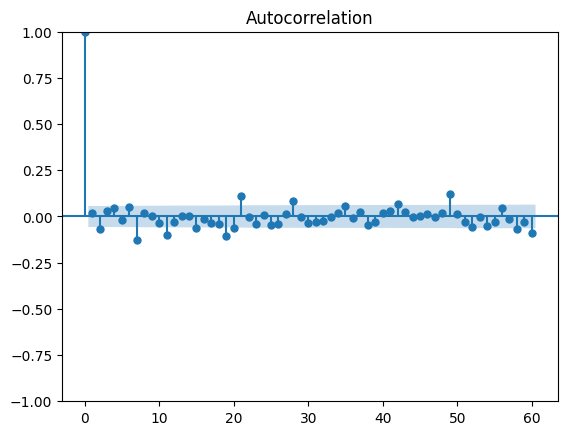

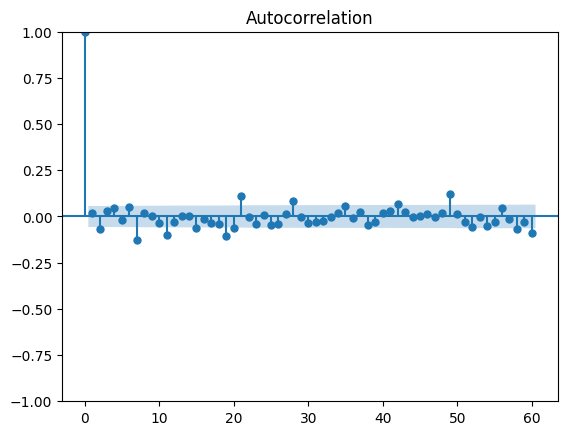

In [28]:
# check residuals
residuals = model_ar.resid
plot_acf(residuals, lags=60)


Since there is some correlation in lags 22 and 49, we check the performance of the model using those

In [29]:
param_p = [1,2,3,4,6,7,22,49] #last reliable arima model
model_ar = ARIMA(ts_r1.astype(int), order=(param_p,param_d,param_q)).fit()
print(model_ar.summary())

                                          SARIMAX Results                                          
Dep. Variable:                                  passengers   No. Observations:                 1186
Model:             ARIMA([1, 2, 3, 4, 6, 7, 22, 49], 1, 0)   Log Likelihood                   0.000
Date:                                     Tue, 13 May 2025   AIC                             18.000
Time:                                             08:04:43   BIC                             63.697
Sample:                                                  0   HQIC                            35.225
                                                    - 1186                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8411         -0       -in

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [30]:
param_p = [1,2,3,4,6,7,49] # fail to converge. discarded
model_ar = ARIMA(ts_r1.astype(int), order=(param_p,param_d,param_q)).fit()
print(model_ar.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                              passengers   No. Observations:                 1186
Model:             ARIMA([1, 2, 3, 4, 6, 7, 49], 1, 0)   Log Likelihood                -323.809
Date:                                 Tue, 13 May 2025   AIC                            663.618
Time:                                         08:05:01   BIC                            704.238
Sample:                                              0   HQIC                           678.929
                                                - 1186                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3738      0.094      3.967      0.000       0.189       0

In [31]:
param_p = [1,2,3,4,7,49] #no improvement
model_ar = ARIMA(ts_r1.astype(int), order=(param_p,param_d,param_q)).fit()
print(model_ar.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                           passengers   No. Observations:                 1186
Model:             ARIMA([1, 2, 3, 4, 7, 49], 1, 0)   Log Likelihood                   0.000
Date:                              Tue, 13 May 2025   AIC                             14.000
Time:                                      08:05:17   BIC                             49.542
Sample:                                           0   HQIC                            27.397
                                             - 1186                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5022         -0       -inf      0.000       1.502       1.502
ar.L2          0.62

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1431: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Adding them doesn't seem to improve the model, either failed to converge or give high values taken in consideration the complexity

## Seasonality
The first seasonality is directly infered from the previous ACF plot, but apparently after removing the weekly seasonality there is still some pattern. <br>
Anyhow, further analysis is not showing any strong seasonality beyond that. This is completely against direct intution, since there is yearly seasonality (the pattern of peak and lows repeat every year, aproximately). Nevertheless, one of the challenges is precisely a vague yearly seasonality, due to the overlap of two different calendars, gregorian and hijjri, which affect diferently the demand. After seasonality decomposition, seems clear that there is both weekyl and yearly sesonality.<br>

In [32]:
df_r1.shape

(1186, 1)

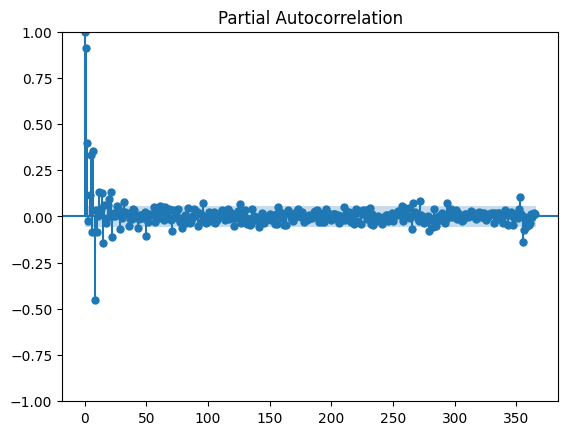

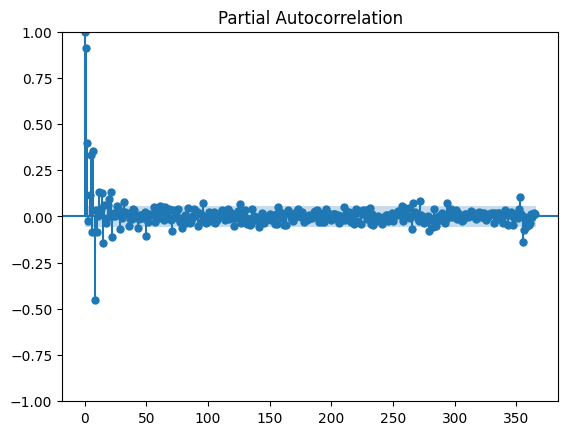

In [33]:
plot_pacf(df_r1['Y'], lags=365)

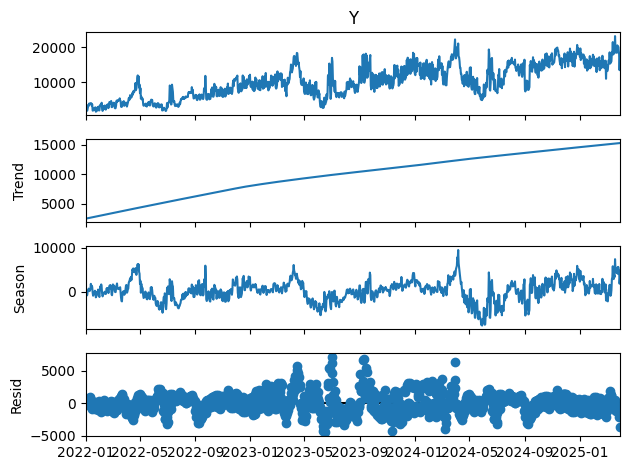

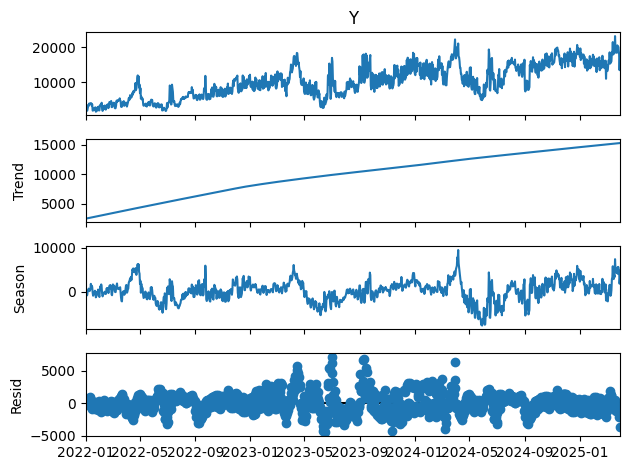

In [34]:
stl = STL(df_r1["Y"], period=365)
result = stl.fit()
result.plot()


Try with more than one tool, but similar results

08:05:20 - cmdstanpy - INFO - Chain [1] start processing
08:05:20 - cmdstanpy - INFO - Chain [1] done processing


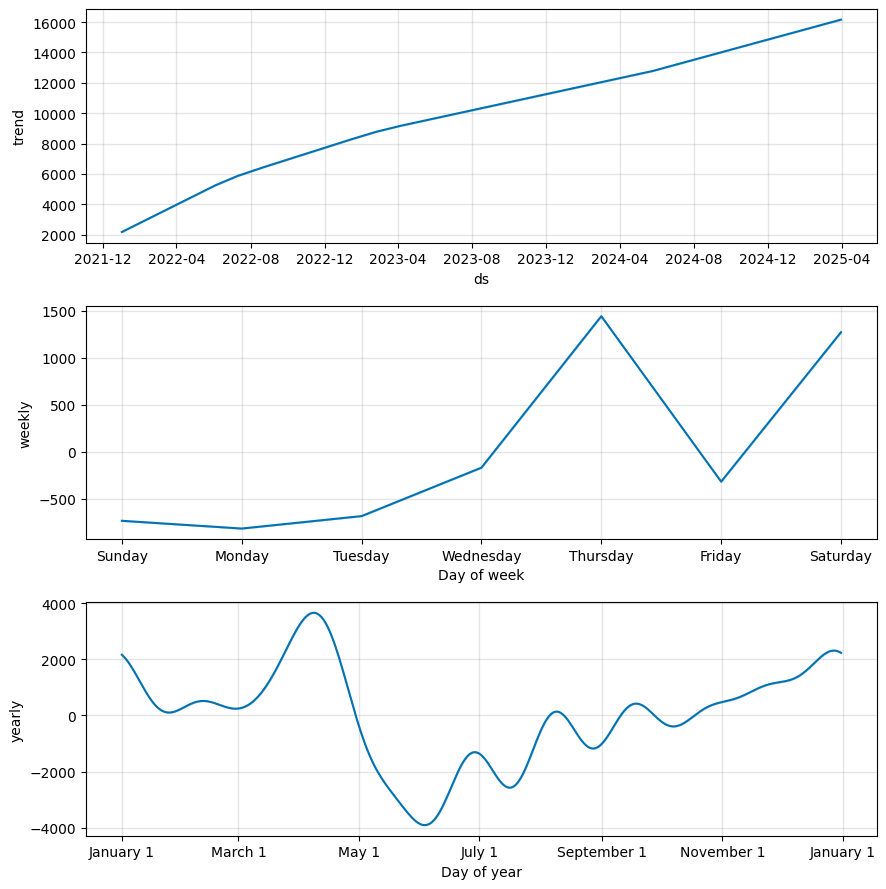

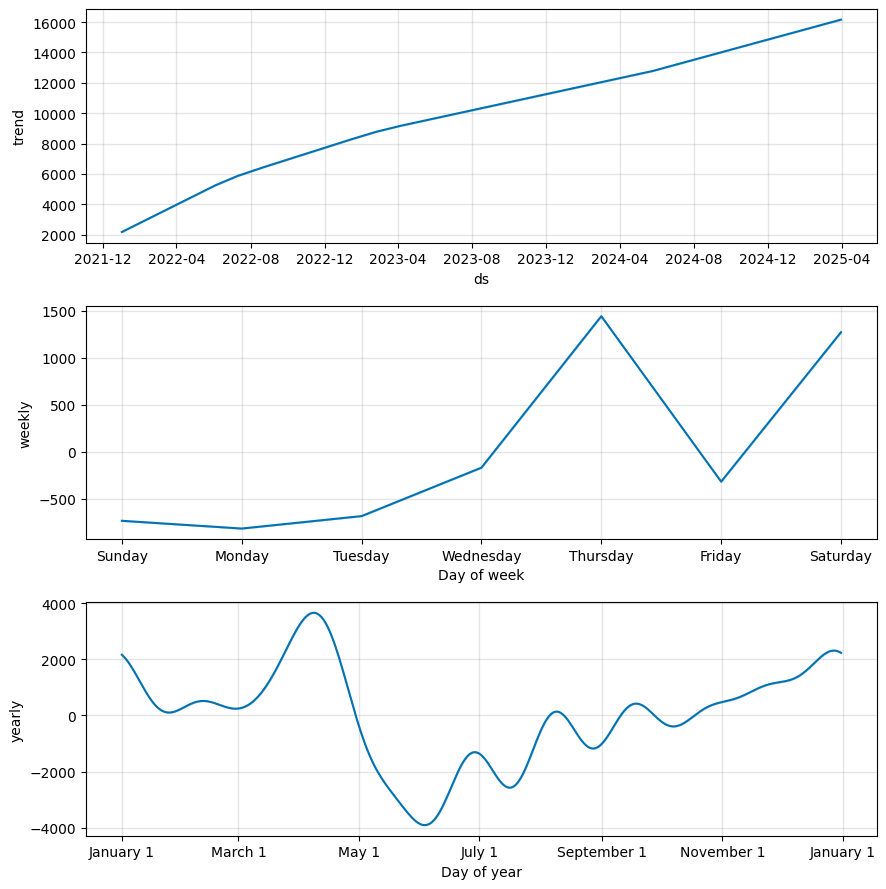

In [35]:
df_prophet = df_r1.rename(columns={"Y": "y"})
df_prophet['ds'] = df_r1.index
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(df_prophet)
forecast = model.predict(df_prophet)
model.plot_components(forecast)


Try spectral analysis to try to get the seasonalities

C:\Users\Joan\AppData\Local\Temp\ipykernel_796\3727564291.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.bar(1/freqs, power)  # Invert frequency to get period on X-axis
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\transforms.py:2035: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\transforms.py:369: RuntimeWarning: invalid value encountered in scalar subtract
  return (x0, y0, x1 - x0, y1 - y0)


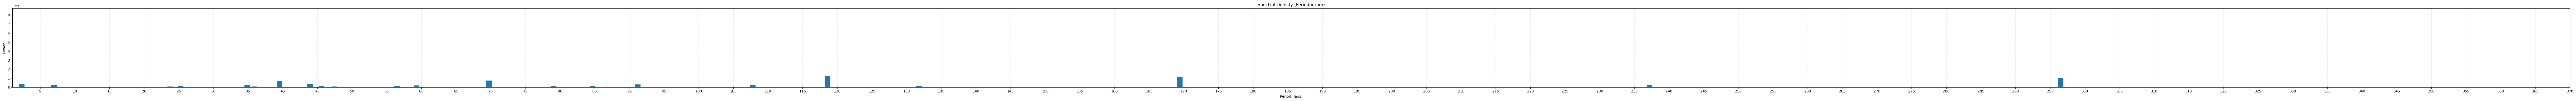

In [36]:
# Convert to numpy array
signal = ts_r1.astype(float).values

# Perform spectral analysis
freqs, power = periodogram(signal)

# Plot
ranges = 370
plt.figure(figsize=(100, 4))
plt.bar(1/freqs, power)  # Invert frequency to get period on X-axis
#plt.plot(1/freqs[1:], power[1:] / power.max())  # normalize by max
plt.xlabel("Period (lags)")
plt.ylabel("Power")
plt.title("Spectral Density (Periodogram)")
plt.xticks(range(0,ranges+1,5))
plt.xlim(1, ranges)  # Focus on short- to mid-range cycles
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Even though there are some peaks, those are not in any meaningful lag, so after considering them I discarded as artifacts.

Finally, I will try to understand other effects checking the residuals from the decomposition

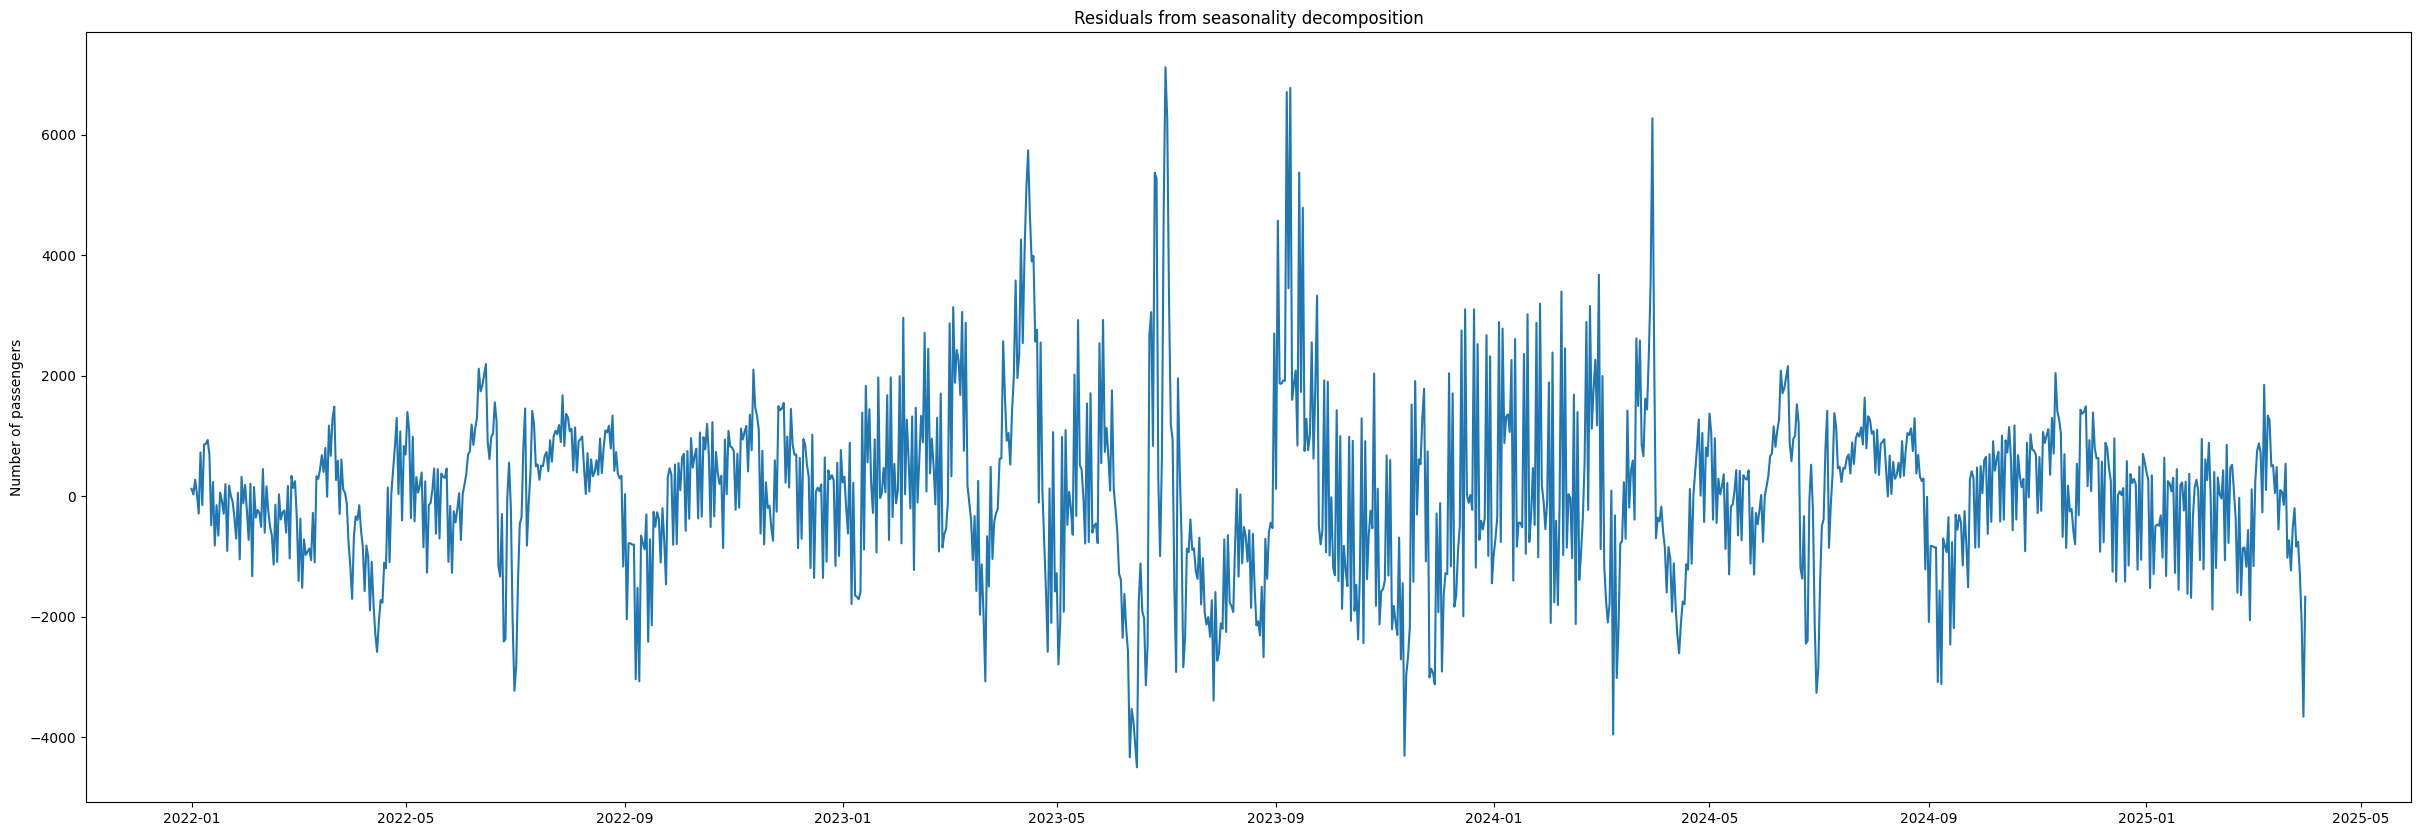

In [37]:
# checking the residuals
plt.figure(figsize=(30,10))
plt.title("Residuals from seasonality decomposition")
plt.ylabel("Number of passengers")
plt.plot(result.resid)


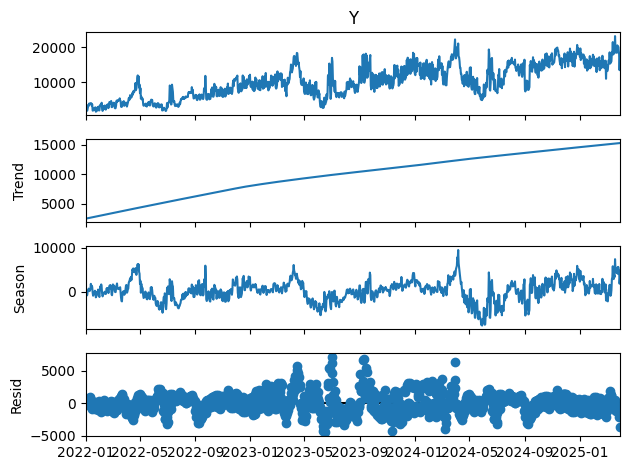

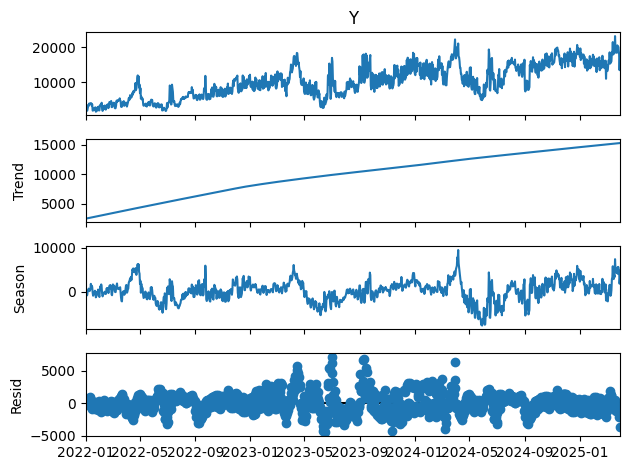

In [38]:
# since 2024 was leap year, lets try again the yearly seasonality (with similar results)
df_test = df_r1[~((df_r1.index.month==2)&(df_r1.index.day==29))]

stl_test = STL(df_test["Y"], period=365)
result_test = stl.fit()
result_test.plot()

## SARIMAX
So two options are going to be explored: Seasonality s=7 and s=365.<br>
If s=365 give value to the model, should be preferably to use it alongisde the lags 7 for AR. On the other hand, maybe it is worth to ignore the yearly seasonality (specially after differenting) and use the seasonality to capture the strong weekly pattern.<br>
Note: Fourier series was tested to model the yearly seasonality, with no satisfactory results.

In [39]:
# SARIMAX with weekyl seasonality
param_p = [1,2,3,4,6]
P, D, Q, s = 2, 1, 1, 7 

# Fit the SARIMA model
model = SARIMAX(df_r1['Y'].astype(float), order=(param_p,param_d,param_q), seasonal_order=(P, D, Q, s), #exog=X_fourier
               )
results = model.fit()
print(results.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                             SARIMAX Results                                             
Dep. Variable:                                                 Y   No. Observations:                 1186
Model:             SARIMAX([1, 2, 3, 4, 6], 1, 0)x(2, 1, [1], 7)   Log Likelihood                 -66.456
Date:                                           Tue, 13 May 2025   AIC                            150.912
Time:                                                   08:05:34   BIC                            196.557
Sample:                                               01-01-2022   HQIC                           168.122
                                                    - 03-31-2025                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

The model is no giving further improvement to the previous one created with lag 7 included in arima.

In [40]:
# SARIMAX with yearly seasonality
#param_p = 1
#param_d = 1
#param_q = 0
#P, D, Q, s = 1, 1, 1, 365 

# Fit the SARIMA model
#model = SARIMAX(df_r1['Y'].astype(float), order=(param_p,param_d,param_q), seasonal_order=(P, D, Q, s), #exog=X_fourier
#               )
#results = model.fit()
#print(results.summary())

The model was to heavy to be calculated (run out of Ram MB)

## Split the data

In [41]:
# Split between training and test
n = len(df_r1)
train_size = int(n * 0.8)
test_size = n - train_size

y_train, y_test = df_r1['Y'][:train_size], df_r1['Y'][train_size:]
#X_train, X_test = X[:train_size], X[train_size:]

## Train the weekly model
For this last training, only a sample of the original data is going to be used, in order to be able to compare with the rest of the models

In [42]:
# SARIMAX with weekyl seasonality
param_p = [1,2,3,4,6, 7]
P, D, Q, s = 0, 0, 0, 0 

# Fit the SARIMA model
model = SARIMAX(y_train.astype(float), order=(param_p,param_d,param_q), seasonal_order=(P, D, Q, s))
results = model.fit()
print(results.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                       
Dep. Variable:                                     Y   No. Observations:                  948
Model:             SARIMAX([1, 2, 3, 4, 6, 7], 1, 0)   Log Likelihood               -8179.276
Date:                               Tue, 13 May 2025   AIC                          16372.552
Time:                                       08:05:35   BIC                          16406.526
Sample:                                   01-01-2022   HQIC                         16385.499
                                        - 08-05-2024                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2427      0.023    -10.603      0.000      -0.288      -0.198
ar.L2      

## Evaluation

In [43]:
# forecasting
y_pred = results.forecast(steps=len(y_test))

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.004223742151024501
Mean Absolute Error: 1946.0871434076494
Mean Squared Error: 6660300.618168777


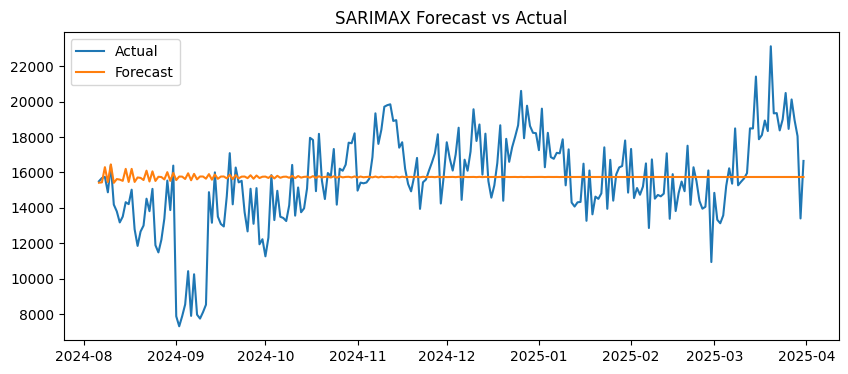

In [44]:
pred = results.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1)
pred_mean = pred.predicted_mean
#ci = pred.conf_int()

plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred_mean, label='Forecast')
#plt.fill_between(y_test.index, ci.iloc[:, 0], ci.iloc[:, 1], color='lightblue', alpha=0.4)
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()


The model failed to capture the variations of demand. The yearly demand model is needed to capture this.

## Train the yearly model
Since the SARIMAX with s=365 was not feasible, we will try to use Fourier terms as exogeneous variables, to try to model the yearly seasonality

In [45]:
# add the lag 364 and 354 as exogoneous features
df_r1["lag_364"] = df_r1["Y"].shift(364).astype(float)
df_r1["lag_354"] = df_r1["Y"].shift(354).astype(float)

# harmonics usually work well for yearly
fourier_year = CalendarFourier(freq='YE', order=5)

dp = DeterministicProcess(
    index=df_r1.index,  
    constant=False,
    order=1,
    seasonal=False,
    additional_terms=[fourier_year],
    drop=True
)

X_fourier = dp.in_sample()

# add the fourier terms to the dataframe
#df_concat = pd.concat([df_r1, X_fourier], axis=1).dropna()
df_concat = df_r1.dropna()

# Split agasin training and test
n = len(df_concat)
train_size = int(n * 0.8)
test_size = n - train_size

y_train, y_test = df_concat['Y'][:train_size], df_concat['Y'][train_size:]
X_train, X_test = df_concat.drop(columns="Y")[:train_size], df_concat.drop(columns="Y")[train_size:]



Train again the ARIMA model with no seasonality, but with the Fourier terms as exogeneous

In [46]:
# check correctness of the index after spliting manually
df_concat.index

DatetimeIndex(['2022-12-31', '2023-01-01', '2023-01-02', '2023-01-03',
               '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07',
               '2023-01-08', '2023-01-09',
               ...
               '2025-03-22', '2025-03-23', '2025-03-24', '2025-03-25',
               '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29',
               '2025-03-30', '2025-03-31'],
              dtype='datetime64[ns]', name='date', length=822, freq=None)

In [47]:
# check columns
X_train.columns

Index(['lag_364', 'lag_354'], dtype='object')

In [48]:
# check NA again
y_train.isna().sum()
X_train.isna().sum()

lag_364    0
lag_354    0
dtype: int64

In [49]:
param_p,param_d,param_q  = 7,0,1 #last reliable arima model

model_ar = ARIMA(y_train.astype(float), order=(param_p,param_d,param_q), exog=X_train).fit()
print(model_ar.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  657
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -5726.156
Date:                Tue, 13 May 2025   AIC                          11476.312
Time:                        08:05:36   BIC                          11530.164
Sample:                    12-31-2022   HQIC                         11497.190
                         - 10-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5937.9682    845.715      7.021      0.000    4280.397    7595.540
lag_364        0.1827      0.048      3.837      0.000       0.089       0.276
lag_354        0.4976      0.032     15.511      0.0

In [50]:
# forecasting
y_pred = model_ar.forecast(steps=len(y_test), exog=X_test)

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: -0.2452457553619003
Mean Absolute Error: 1741.1526563512077
Mean Squared Error: 4661592.886268708


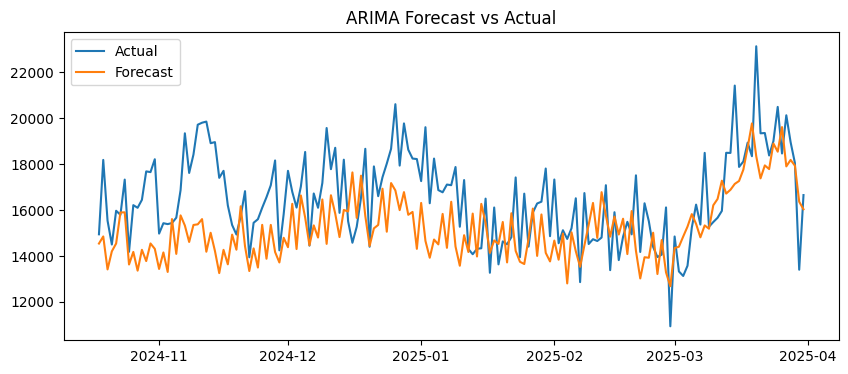

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

The drop on demand, compared with the previous year, which is one of the main reasons why this models have such a wrong predictive power, is because the prices: There was a very important discount in the previous year (2023), reason why the forecast is high as well. In order to have a decent model, it is necessary to model the prices. 

## Parameter for prices
we will use the calculation of revenue with the standard prices compared with the revenue actual got, in order to know the level of discount applied. (Same approach that was used in the linear regression before.)

In [52]:
df_prices = pd.DataFrame({'ratio':data['revenue'] / data['revenue_without_promotion']})
df_prices.index = df_r1.index
df_r1['ratio_prices'] = df_prices['ratio']

In [53]:
# estimation of price elasticity
# log-log
X = np.log(df_prices['ratio'].astype(float))
y = np.log(df_r1['Y'].astype(float))

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     87.12
Date:                Tue, 13 May 2025   Prob (F-statistic):           4.88e-20
Time:                        08:05:36   Log-Likelihood:                -960.56
No. Observations:                1186   AIC:                             1925.
Df Residuals:                    1184   BIC:                             1935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9860      0.019    476.923      0.0

In [54]:
# change the lag features based on this values, in order to normalize all the occupancy metrics to standard prices
elasticity = -.7661 # the coefficient in the log log model before
df_r1['Y_adjusted'] = df_r1['Y'].astype(float) * (1/df_prices['ratio']).astype(float) ** elasticity

#recalculate
df_r1["lag_364"] = df_r1["Y_adjusted"].shift(364).astype(float)
df_r1["lag_354"] = df_r1["Y_adjusted"].shift(354).astype(float)

df_concat = df_r1.dropna()

# split again
n = len(df_concat)
train_size = int(n * 0.8)
test_size = n - train_size
X_train, X_test = df_concat[["lag_364","lag_354"]][:train_size], df_concat[["lag_364","lag_354"]][train_size:]
y_train, y_test = df_concat['Y_adjusted'][:train_size],  df_concat['Y_adjusted'][train_size:]


In [55]:
X_train

,lag_364,lag_354
date,,
2022-12-31,2439.861216,3784.760900
2023-01-01,1906.428251,3782.529692
2023-01-02,1795.115017,3755.619983
2023-01-03,1715.310668,3088.486166
2023-01-04,2321.389907,3459.810224
...,...,...
2024-10-13,8721.062468,11078.544109
2024-10-14,9238.401515,13688.547031
2024-10-15,9832.698668,9782.000000


In [56]:
# fit the model again with the new features
model_ar_prices = ARIMA(y_train.astype(float), order=(param_p,param_d,param_q), exog=X_train).fit()
print(model_ar_prices.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Y_adjusted   No. Observations:                  657
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -5594.350
Date:                Tue, 13 May 2025   AIC                          11212.699
Time:                        08:05:37   BIC                          11266.552
Sample:                    12-31-2022   HQIC                         11233.577
                         - 10-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5222.7642    787.572      6.631      0.000    3679.152    6766.376
lag_364        0.0904      0.036      2.542      0.011       0.021       0.160
lag_354        0.6368      0.028     22.574      0.0

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
df_concat

,Y,lag_364,lag_354,ratio_prices,Y_adjusted
date,,,,,
2022-12-31,12096,2439.861216,3784.760900,0.9888859489407958334998631072,11992.874434
2023-01-01,8955,1906.428251,3782.529692,0.9802780829986304664334667344,8819.384630
2023-01-02,8601,1795.115017,3755.619983,0.9810531418345228332149422729,8475.876053
2023-01-03,8613,1715.310668,3088.486166,0.9811984468688429398625709688,8488.664548
2023-01-04,8682,2321.389907,3459.810224,0.9802119967116710078045663018,8550.077353
...,...,...,...,...,...
2025-03-27,20125,18222.443541,16991.361402,0.9669720642826494792785507187,19613.788999
2025-03-28,18955,20225.867637,16497.451711,0.9811815574090147154517080795,18681.123265
2025-03-29,18050,21974.551967,12108.586413,0.9807528598039967248183553562,17783.244636


In [58]:
y_pred = model_ar_prices.forecast(steps=len(y_test), exog=X_test)

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.5549309352686403
Mean Absolute Error: 1535.0178321295164
Mean Squared Error: 3848790.5837394376


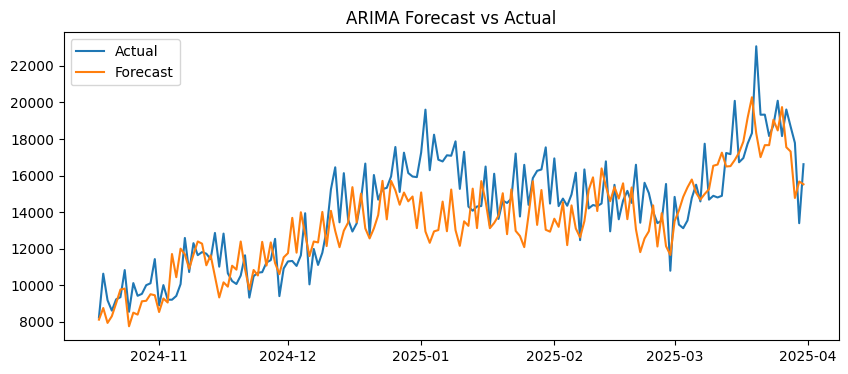

In [59]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

There is some obvious improvement, but still it lacks most of the explanation power of the data. The growth of demand from one year to another could be one of the reasons (Heteroskedasticity in the limit). The determninist trend of Fourier series did not help, but something simpler could do the job. Aditionally, the services offered has changed so much between years, affecting positively to the demand.

In [60]:
# evaluation for the real passengers, not the adjusted ones
print("R² Score:", r2_score_real(y_test, y_pred, df_concat['ratio_prices'][-test_size:].astype(float), elasticity)) 

R² Score: -0.26961811534083324


Similarly what happened with the linear regression model, the adjustment of real passengers distort the results. For that reason, we will try to predict the real passengers directly, using the ratio of prices as exogenous variable.

# Adding exog variables: Time and Services
Aside of the prices from the previous step, the time and services are added as a need to adjust the demand for the future periods, and not smooth the line too often.<br>
Initially, the advance of weeks, the year, and the number of services were added. Later on, the year was removed since it was mispredicting the test values for 2025, and it is somehow redundant with the weeks.<br>

In [61]:
df_r1

,Y,lag_364,lag_354,ratio_prices,Y_adjusted
date,,,,,
2022-01-01,2579,NaN,NaN,0.9301649164111670513016624656,2439.861216
2022-01-02,2038,NaN,NaN,0.9165732780472706508919947275,1906.428251
2022-01-03,1900,NaN,NaN,0.9285584929059775813534348745,1795.115017
2022-01-04,1810,NaN,NaN,0.9322652655236822523575951770,1715.310668
2022-01-05,2440,NaN,NaN,0.9370241214458653349569073757,2321.389907
...,...,...,...,...,...
2025-03-27,20125,18222.443541,16991.361402,0.9669720642826494792785507187,19613.788999
2025-03-28,18955,20225.867637,16497.451711,0.9811815574090147154517080795,18681.123265
2025-03-29,18050,21974.551967,12108.586413,0.9807528598039967248183553562,17783.244636


In [62]:
# add the new features to the model
df_extra = pd.DataFrame({'num_services':data['number_of_services'], 'week_num':data['train_week_num']})
df_extra.index = df_r1.index
df_r1['num_services'] = df_extra['num_services']
#df_r1['year'] = df_r1.index.year
#df_r1['time'] = ((df_r1.index - min(df_r1.index)) / pd.Timedelta(weeks=1)).astype(int)
df_r1['ratio_prices'] = df_r1['ratio_prices'].astype(float)

# get the clean df again
df_concat = df_r1.dropna()

# split again
n = len(df_concat)
train_size = int(n * 0.8)
test_size = n - train_size
x_features = ["lag_364",
              "lag_354", 
              "num_services",
              #"time",
              #"year", 
              "ratio_prices"]
X_train, X_test = df_concat[x_features][:train_size], df_concat[x_features][train_size:]
y_train, y_test = df_concat['Y'][:train_size],  df_concat['Y'][train_size:]

In [63]:
# fit the model again with the new features
model_ar_services = ARIMA(y_train.astype(float), order=(param_p,param_d,param_q), exog=X_train).fit()
print(model_ar_services.summary())

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  657
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -5456.133
Date:                Tue, 13 May 2025   AIC                          10940.267
Time:                        08:05:39   BIC                          11003.094
Sample:                    12-31-2022   HQIC                         10964.624
                         - 10-17-2024                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4053.2862    987.500      4.105      0.000    2117.823    5988.750
lag_364          0.1304      0.027      4.894      0.000       0.078       0.183
lag_354          0.1907      0.029      6.63

C:\Users\Joan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
df_concat

,Y,lag_364,lag_354,ratio_prices,Y_adjusted,num_services
date,,,,,,
2022-12-31,12096,2439.861216,3784.760900,0.988886,11992.874434,32
2023-01-01,8955,1906.428251,3782.529692,0.980278,8819.384630,26
2023-01-02,8601,1795.115017,3755.619983,0.981053,8475.876053,26
2023-01-03,8613,1715.310668,3088.486166,0.981198,8488.664548,26
2023-01-04,8682,2321.389907,3459.810224,0.980212,8550.077353,26
...,...,...,...,...,...,...
2025-03-27,20125,18222.443541,16991.361402,0.966972,19613.788999,54
2025-03-28,18955,20225.867637,16497.451711,0.981182,18681.123265,53
2025-03-29,18050,21974.551967,12108.586413,0.980753,17783.244636,52


In [65]:
y_pred = model_ar_services.forecast(steps=len(y_test), exog=X_test)

# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.5455926145145626
Mean Absolute Error: 1091.220554101893
Mean Squared Error: 1701079.667628544


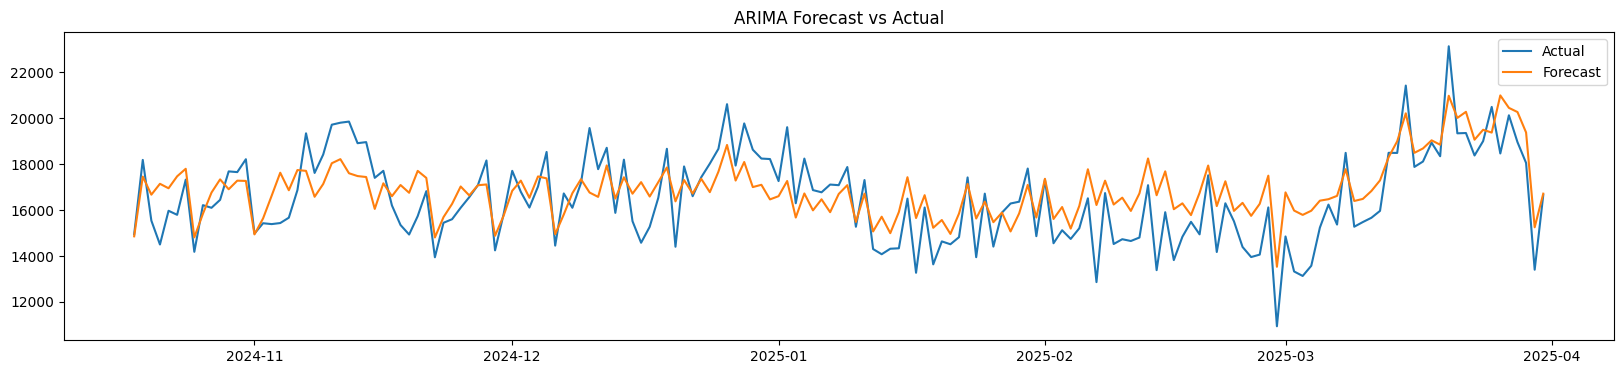

In [66]:
plt.figure(figsize=(20, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

In order to see if the different exogeneous variables share the same information, we cheched the correlation between them, and adjust accordingly. Time and year were removed from the final model.

                     Y   lag_364   lag_354  ratio_prices  Y_adjusted  \
Y             1.000000  0.687243  0.745158     -0.268624    0.827566   
lag_364       0.687243  1.000000  0.725800     -0.039702    0.659934   
lag_354       0.745158  0.725800  1.000000     -0.069922    0.705348   
ratio_prices -0.268624 -0.039702 -0.069922      1.000000    0.303287   
Y_adjusted    0.827566  0.659934  0.705348      0.303287    1.000000   
num_services  0.773491  0.649190  0.648186      0.004326    0.760156   

              num_services  
Y                 0.773491  
lag_364           0.649190  
lag_354           0.648186  
ratio_prices      0.004326  
Y_adjusted        0.760156  
num_services      1.000000  


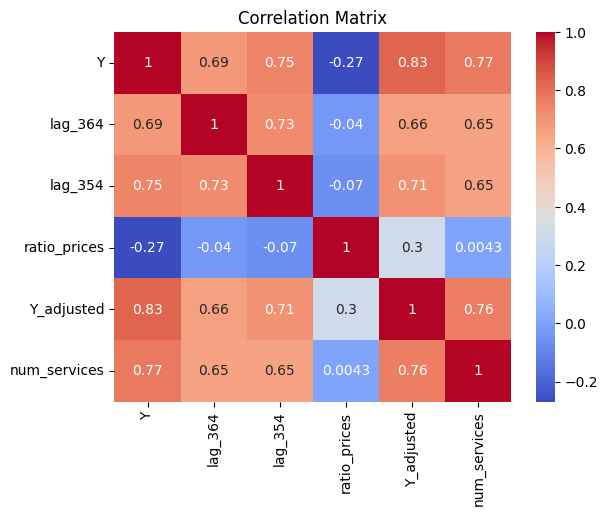

In [67]:
corr_matrix = df_concat.corr()
print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Export

In [68]:
X_train.columns.tolist()

['lag_364', 'lag_354', 'num_services', 'ratio_prices']

In [69]:
#save the features
import json

with open(os.path.join(ROOT_DIR, "features", "exog_arima.json"), "w") as f:
    json.dump(X_train.columns.tolist(), f)

# save the model
joblib.dump(model_ar_services, os.path.join(ROOT_DIR, "models", "model_arima.pkl"))

['C:\\Users\\Joan\\Documents\\jpnb\\models\\model_arima.pkl']

In [70]:
X_train.columns.tolist()

['lag_364', 'lag_354', 'num_services', 'ratio_prices']